In [1]:
import numpy as np
from pylab import *
import scipy
from collections import defaultdict
from scipy import  signal as SIG
from skimage.draw import disk, ellipse

import astropy
from astropy import units as ur
from astropy import constants as cc
from astropy.modeling.physical_models import BlackBody



# Summary

To estimate the thermal background we use the following procedure. We know well the blackbody curve and the A-Omega product. We must estimate the temperature and emissivity of the MIRMOS optical path. The temperature of the dome, corrector, ADC, and mirrors is estimated to be 293 K. The atmosphere is given a single emissivity and temperature of 0.2 and 293 K, respectively.  The radiometric equations for the thermal radiation in K are estimated at a wavelength of 2.45 µm and ambient temperature 283 K. Using the astropy BlackBody function, we find that the photon rate at 2.45 µm is 1.6e12 photon / s / bandwidth / solid angle / area. The solid angle-area product, sometimes called Grasp or AOmega, is computed as pixel area x camera solid angle or 130 µm^2 sr. The emissivities are tabulated at 2.45 µm as follows:
atm_ϵ = 0.2
mirror_ϵ = 0.05
ADC_ϵ = 1 - (1-0.01)**4
Corrector_ϵ = 0.01

For a total emissivity of about 30%. We find that in a single pixel, the typical photon count in a 180-s exposure is about 11,000 photon, and in a 2x2 pixel area, the count is about 40k photon. Forcing a 5-sigma detection in one hour means that for a background of 800 kphotons (20 exposures x 40k photons) the signal must produce 4500 photons in one hour. 

The geometry is as follows. The point-spread function is estimated to be 2.44 x 2.45 µm x 11 (11 is Magellan's focal ratio) or 65 µm in the spatial axis, and 22 mm (or 118 / .35x larger : pupil diameter/slit width -- a coarse approximation) in the orthogonal direction. The resulting pupil is quite "soft".

We then place a mask (simulating the Lyot stop) on the pupil image. The mask diameter is adjusted, as well as the masks misalignment.



# Radiometry

In [2]:
wavelength = 2.45*ur.micron
epp = (cc.h*cc.c/wavelength).to(ur.erg)
print(epp)


blackbody = BlackBody(temperature=283*ur.Kelvin)
q_rate = blackbody(wavelength).to(ur.erg/ur.cm**2/ur.s/ur.sr/ur.micron, equivalencies=ur.spectral_density(wavelength)) / epp
q_rate

8.107942274077259e-13 erg


<Quantity 1.61846068e+12 1 / (micron s sr cm2)>

In [3]:
def fno_to_Omega(fnum):
    " See eq. 24 https://www.labsphere.com/site/assets/files/2551/integrating_sphere_theory_apps_tech_guide.pdf"
    
    return np.pi/(4*fnum*fnum) * ur.steradian


In [4]:
pixel_size = 18*ur.micron
fno_cam = 1.4

AΩ = (pixel_size)**2 * fno_to_Omega(fno_cam) # Pixel
AΩ 

<Quantity 129.83112497 micron2 sr>

Chain:
Atmosphere x Mirrors x ADC x Corrector 

In [5]:
# all below at about 2.45 µm
atm_ϵ = 0.2
mirror_ϵ = 0.05
ADC_ϵ = 1 - (1-0.01)**4
Corrector_ϵ = 0.01

total_ϵ = np.sum([atm_ϵ, mirror_ϵ, ADC_ϵ, Corrector_ε])

total_ϵ

np.float64(0.29940399000000006)

In [6]:
spectral_res = 4000
pixels_per_res = 2.4
BandWidth = wavelength/spectral_res/pixels_per_res
exp_time = 180*ur.second

efficiency = 0.4

In [7]:
bgd_photon_per_pixel = (efficiency * total_ϵ * q_rate * AΩ * BandWidth * exp_time).to(1)

In [8]:
np.round(bgd_photon_per_pixel)

<Quantity 11560.>

In [9]:
sig = 300
bgd = 10000
sig/np.sqrt(sig + bgd)*np.sqrt(4)

np.float64(5.911975668985759)

In "conclusion" the background in a 3-m exposure will be about 10,000 photon / pixel, so to achieve a SNR of 5 per pixel the above is needed

# Geometry

In [10]:
mm = 10
µm = 0.01

shape = (200*mm,200*mm) # each tic = 0.1 mm

center = (100*mm,100*mm)
pupil_radius = 118*mm/2

In [11]:
shape

(2000, 2000)

In [12]:
def make_pupil(center, radius, shape):
    pupil = np.zeros(shape)

    XX,YY = disk(center, pupil_radius, shape=shape)
    pupil[XX,YY] = 1

    return pupil

    

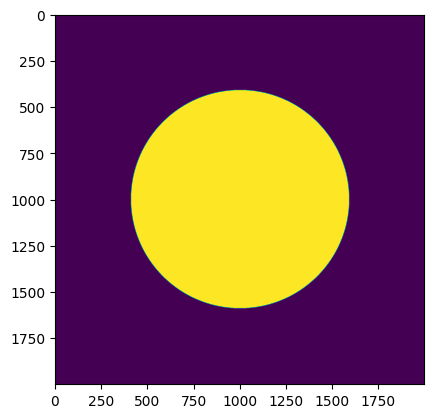

In [13]:

pupil = make_pupil(center, pupil_radius, shape)
imshow(pupil)

0.64416 217.17394285714286


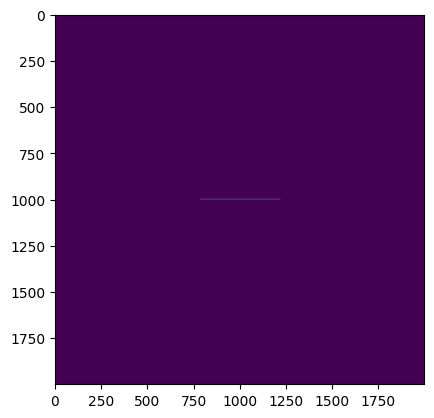

In [14]:
PSF = np.zeros(shape)

X_w = 2.44 * 2.4 * 11 * µm  # 2.44 x lamda x fno
Y_w = X_w*118/.35
print(X_w, Y_w)

XX,YY = ellipse(1000,1000,X_w,Y_w)
PSF[XX,YY] = 1


PSF /= np.sum(PSF)

imshow(PSF)

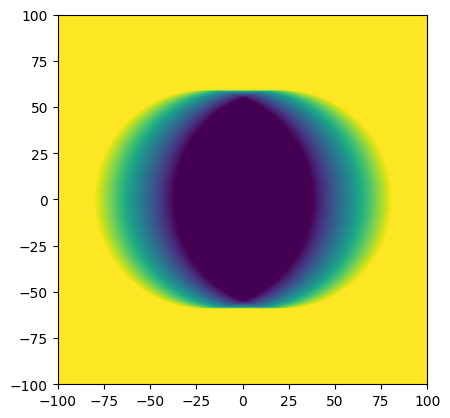

In [15]:
pupil_image = SIG.fftconvolve(pupil, PSF, mode='same')
imshow(1-pupil_image, extent=[-100,100,-100,100])


In [16]:
np.sum(pupil_image * pupil)/np.sum(pupil*pupil)

np.float64(0.882989227852914)

In [17]:
def lune_area(radius, offset):
    """ Area of a lune, simplified from https://mathworld.wolfram.com/Lune.html """
    b = radius
    c = offset

    q2 = np.acos(1-c/b) + np.atan2((b-c),np.sqrt((2*b-c)*c)) + 2*np.atan2(c**2,np.sqrt(4*b**2*c**2-c**4))
    op = np.sqrt(4*b*b * c*c - c**4) - b**2*np.pi + 2*b**2*q2
    return 0.5*op


print("Should be 1.91: ", lune_area(1,1))
print("Should be 3.95793: ", lune_area(2,1))

print(lune_area(118/2, 0.1))

Should be 1.91:  1.9132229549810364
Should be 3.95793:  3.957933714240337
11.799998587568552


In [18]:
excess_factor = 1/total_ε
print(excess_factor)
# The little bit of hot light coming from the hot world has much higher emissivity, so it increases the background level accordingly

3.339968849446528


In [27]:
results = defaultdict(list)

MX = np.sum(pupil*pupil)
offsets = np.array([0, 1, 2, 5, 10, 20, 50]) # Again in 100 µm tick
xs = offsets * 0.1

radii = np.array([118, 119, 120, 117, 116, 115, 114])*mm/2

for pupil_radius in radii:
    for offset in offsets:
        #v = (center[0], center[1]+offset)
        v = (center[0]+offset, center[1])

        mask = make_pupil(v, pupil_radius, shape)
        science = np.sum(mask*pupil_image)/MX
        bgd = np.sum(mask*(1-pupil_image)/MX)*excess_factor
        results[pupil_radius*2/mm].append([science,bgd])

print(results[118][-1])

[np.float64(0.8670177320065717), np.float64(0.44415663262680055)]


[3.76023141 3.76040189 3.76023141 3.75854215 3.75263653 3.73200109
 3.62373367]
[3.75088342 3.75095848 3.75088342 3.74975577 3.74446357 3.72450575
 3.61808732]
[3.73724832 3.73730575 3.73724832 3.73637305 3.73246835 3.71425138
 3.61072423]
[3.76371985 3.76379529 3.76371985 3.76256449 3.75712692 3.73666348
 3.627598  ]
[3.762565   3.76262527 3.762565   3.76163984 3.75752078 3.73835521
 3.62958544]
[3.75751451 3.75756614 3.75751451 3.75672149 3.75323907 3.73679059
 3.62965003]
[3.74901958 3.74906692 3.74901958 3.74831722 3.74525273 3.73145409
 3.62768604]


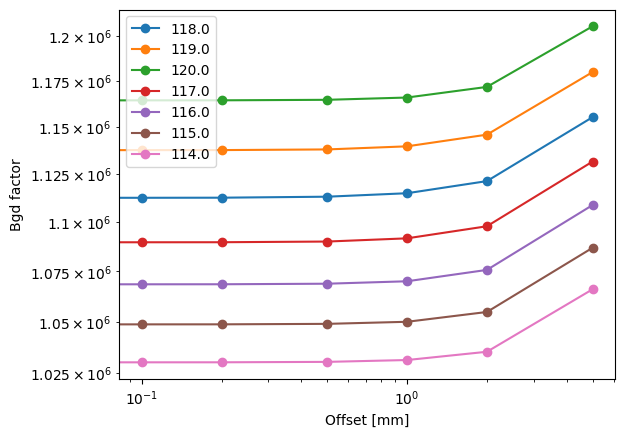

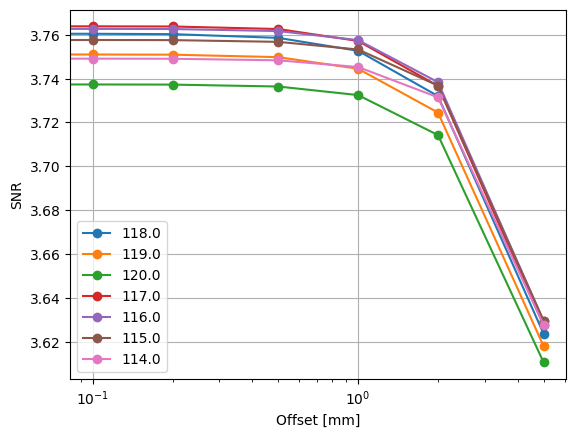

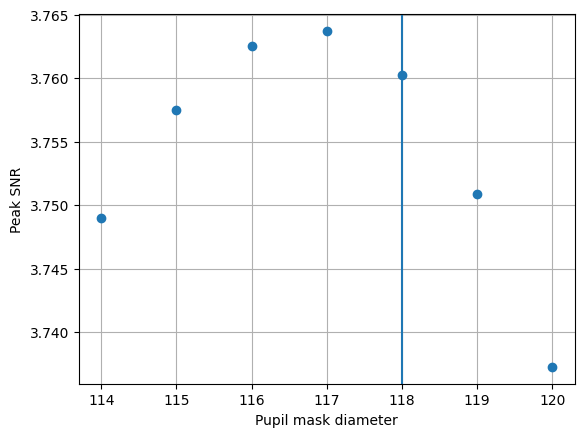

In [28]:

sg0, bg0 = results[118][0] # The base level is a 118-mm mask on axis
x_a = []
y_a = []


for key,res in results.items():
    sg, bgd = (np.array(res).T) 
    
    """snr = signal/√√(signal+bgd)"""
    sg *= 4_500
    bgd = 800_000 * (1 + bgd)

    
    snr = sg/np.sqrt(sg+bgd)
    print(snr)


    x_a.append(key)
    y_a.append(snr[0])

    figure(1)
    loglog(xs, bgd, 'o-')

    figure(2)
    semilogx(xs, snr, 'o-')


figure(1)
legend(results.keys())
xlabel("Offset [mm]");
ylabel("Bgd factor")

figure(2)
legend(results.keys())
xlabel("Offset [mm]");
ylabel("SNR")
grid(True)

figure(3)


plot(x_a,y_a,'o')
axvline(118)
xlabel("Pupil mask diameter")
ylabel("Peak SNR")
grid(True)
    